<a href="https://colab.research.google.com/github/SondipPoulSingh/Deep-Learning/blob/main/Tuning_with_Transfer_Learning_and_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Sample Data

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

! kaggle datasets download -d salader/dogs-vs-cats
# command from the dataset API https://www.kaggle.com/datasets/salader/dogs-vs-cats

 99% 1.06G/1.06G [00:04<00:00, 248MB/s]
100% 1.06G/1.06G [00:04<00:00, 267MB/s]


In [2]:
from zipfile import ZipFile

with ZipFile('/content/dogs-vs-cats.zip','r') as zip:
  zip.extractall('/content')

### Importing libraries, Applying Augmentation

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# this is the augmentation configuration we will use for training
train_data = ImageDataGenerator(rotation_range=30,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                   )
test_data = ImageDataGenerator(rescale=1./255)

In [14]:
# this is a generator that will read pictures found in
# subfolers of 'content/train', and indefinitely generate
# batches of augmented image data

train_datagen = train_data.flow_from_directory(
    '/content/train',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32
)

test_datagen = test_data.flow_from_directory(
    '/content/test',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Model_building

In [15]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3)
                  )

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [27]:
model=Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [28]:
conv_base.trainable=False

In [29]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

### Testing

In [22]:
history = model.fit(train_datagen, epochs=5, validation_data=test_datagen)
# validation accuray is better than training accuracy. So it works well.

Epoch 1/5
625/625 [==============================] - 292s 462ms/step - loss: 0.3497 - accuracy: 0.8700 - val_loss: 0.1723 - val_accuracy: 0.9316
Epoch 2/5
625/625 [==============================] - 290s 464ms/step - loss: 0.2286 - accuracy: 0.9028 - val_loss: 0.1804 - val_accuracy: 0.9204
Epoch 3/5
625/625 [==============================] - 301s 481ms/step - loss: 0.1985 - accuracy: 0.9160 - val_loss: 0.1645 - val_accuracy: 0.9302
Epoch 4/5
625/625 [==============================] - 295s 473ms/step - loss: 0.1914 - accuracy: 0.9183 - val_loss: 0.1806 - val_accuracy: 0.9244
Epoch 5/5
625/625 [==============================] - 296s 474ms/step - loss: 0.1880 - accuracy: 0.9214 - val_loss: 0.1508 - val_accuracy: 0.9360


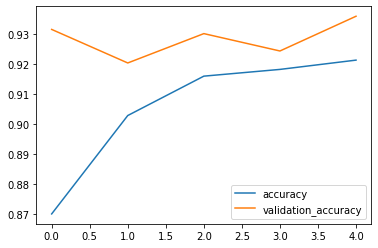

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='validation_accuracy')
plt.legend()
plt.show()
# # Without Augmentation we got overfitting(shown in the second image)

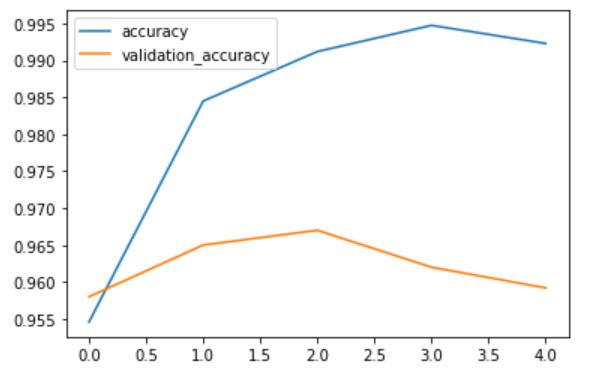

### Tuning

In [30]:
conv_base.trainable=True
for layer in conv_base.layers:
  #print(layer.name, layer.trainable)
  if("block5" not in layer.name):
    layer.trainable=False

In [32]:
for layer in conv_base.layers:
  print(layer.name, layer.trainable) # last conv layer is now trainable

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [31]:
tuned_model=Sequential()
tuned_model.add(conv_base)
tuned_model.add(Flatten())
tuned_model.add(Dense(256,activation='relu'))
tuned_model.add(Dense(1,activation='sigmoid'))

tuned_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               6422784   
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 13,502,465
Non-trainable params: 7,635,264
_________________________________________________________________


In [33]:
tuned_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

In [34]:
history = tuned_model.fit(train_datagen, epochs=5, validation_data=test_datagen)

Epoch 1/5
625/625 [==============================] - 310s 492ms/step - loss: 0.7312 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
625/625 [==============================] - 290s 464ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
625/625 [==============================] - 288s 460ms/step - loss: 0.6932 - accuracy: 0.4953 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
625/625 [==============================] - 289s 462ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
625/625 [==============================] - 288s 460ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5000
